In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

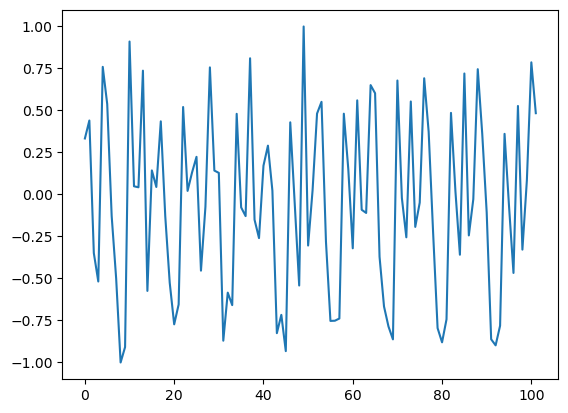

In [5]:
objetivo_train = 2*(objetivo_train-np.min(objetivo_train))/(np.max(objetivo_train)-np.min(objetivo_train)) - 1
conjunto_train = conjunto_train*(np.pi) + np.pi/2
plt.plot(objetivo_train)
plt.show()

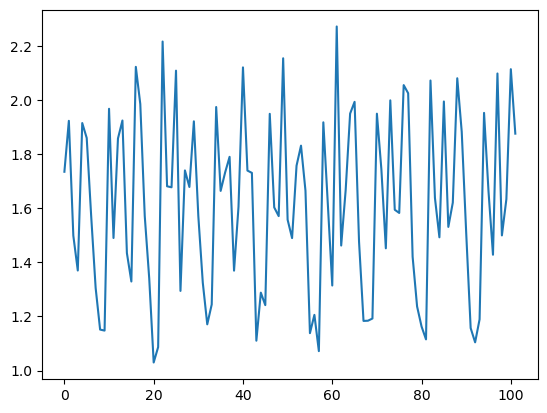

In [6]:
plt.plot(conjunto_train[:,0])
plt.show()

In [7]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
        
    for i in range(n_qubits-1):
        feature_map.cx(i,i+1)
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    
    ansatz = RealAmplitudes(n_qubits)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [8]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [10]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [11]:
regressor2 = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error',
    optimizer=L_BFGS_B(maxiter=30),
    callback=callback_graph
)

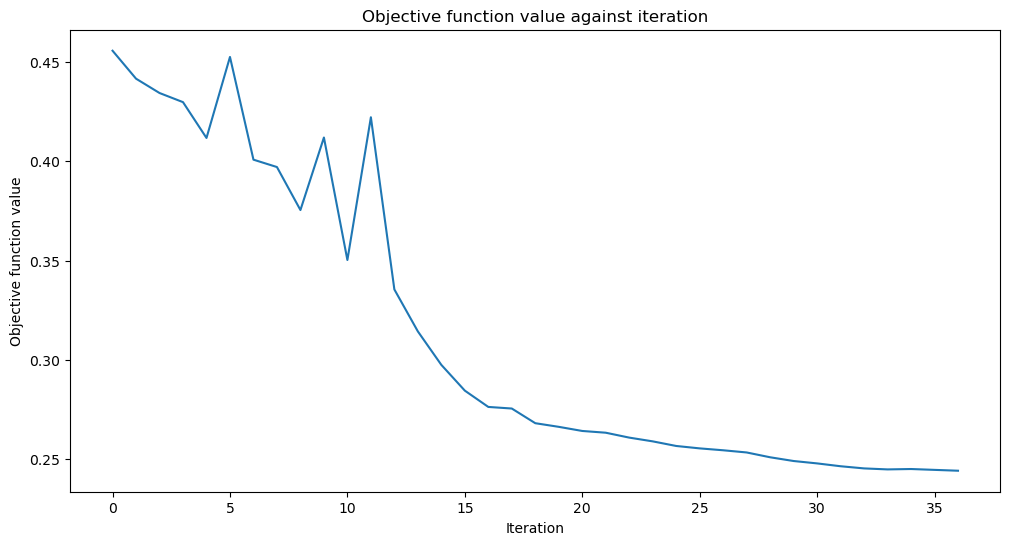

0.672943714787418

In [12]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor2.fit(conjunto_train, objetivo_train)
regressor2.score(conjunto_train, objetivo_train)

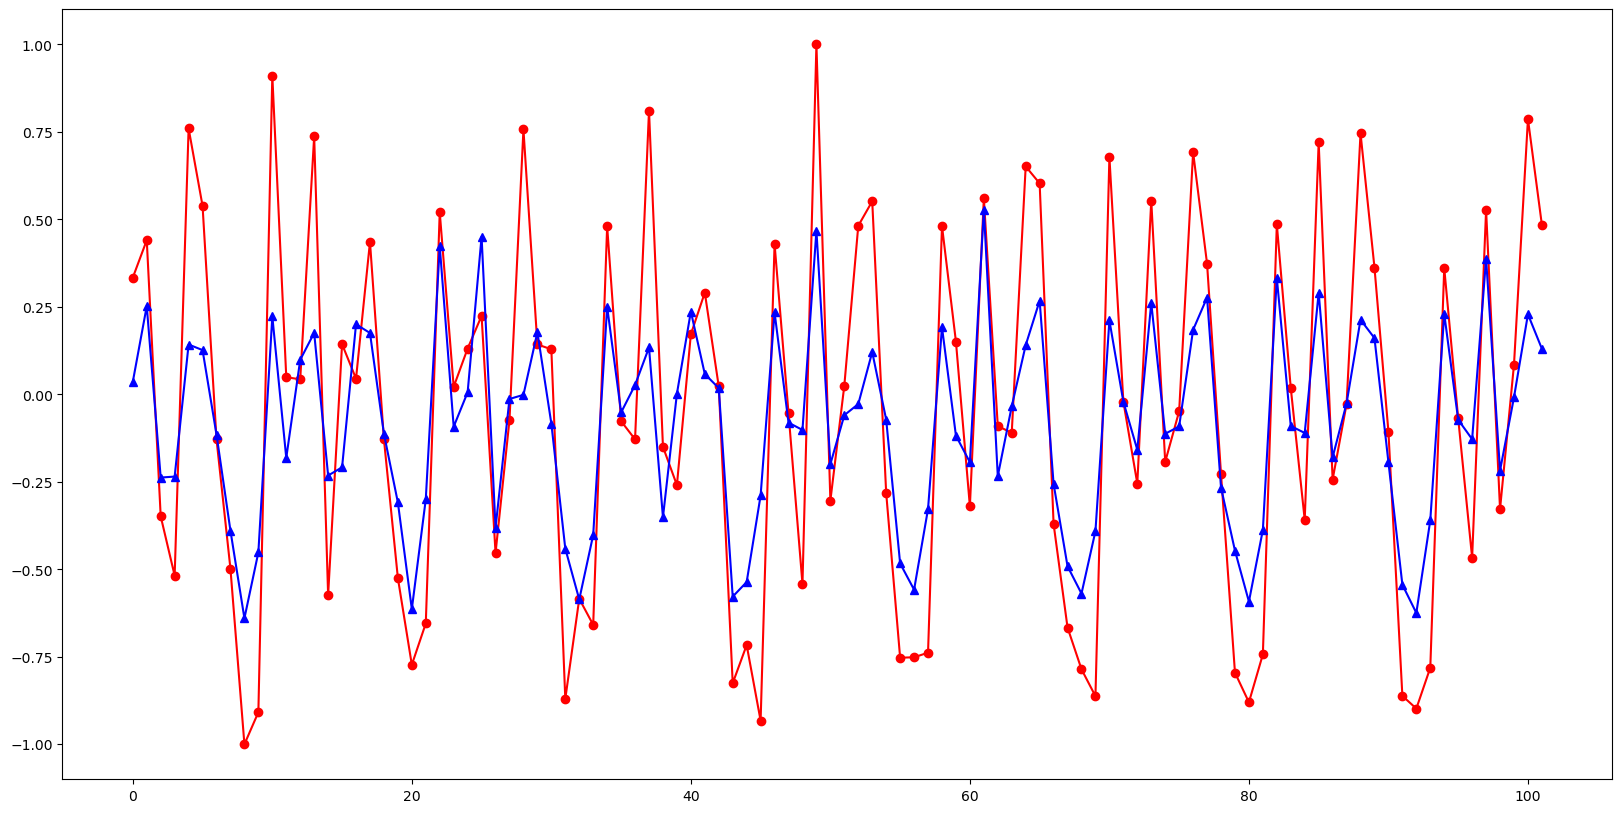

array([-3.32363154e-01, -4.77365316e-02,  2.97413428e-01, -2.11672672e-01,
       -1.62738786e-01, -1.19868828e-01,  1.72353294e-04, -1.31216808e-02,
       -1.86664175e-01, -2.50051304e-01,  7.86502586e-03,  1.50452901e-01,
        1.15252529e+00,  8.17455510e-01, -6.43725077e-01,  1.22895356e+00,
        8.96208593e-02,  2.44684409e-02,  1.59063023e+00,  1.54868523e+00,
       -9.35088087e-02, -1.69687643e-02,  1.56363755e+00,  4.05445567e-01,
       -3.69449092e-02,  1.58988181e+00,  2.93402075e-04, -2.48413252e-03,
        1.59376804e+00,  1.57759165e+00,  2.99130320e-03,  6.57739920e-03,
        1.54192712e+00,  1.48535380e+00,  2.91395767e-02,  1.17790301e+00,
       -7.86152970e-01,  3.74134260e-01,  1.53507087e+00,  1.01130393e-01,
        1.59612783e+00, -2.75196315e-02,  9.23779084e-02,  1.51386439e+00,
        9.52828330e-01, -2.41112253e-02,  2.90323618e-02,  8.23450154e-01])

In [13]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor2.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor2.weights

In [14]:
vqr = VQR(
    feature_map=f1,
    ansatz=f2,
    optimizer=L_BFGS_B(maxiter=30),
    callback=callback_graph,
    loss='absolute_error' ,
)

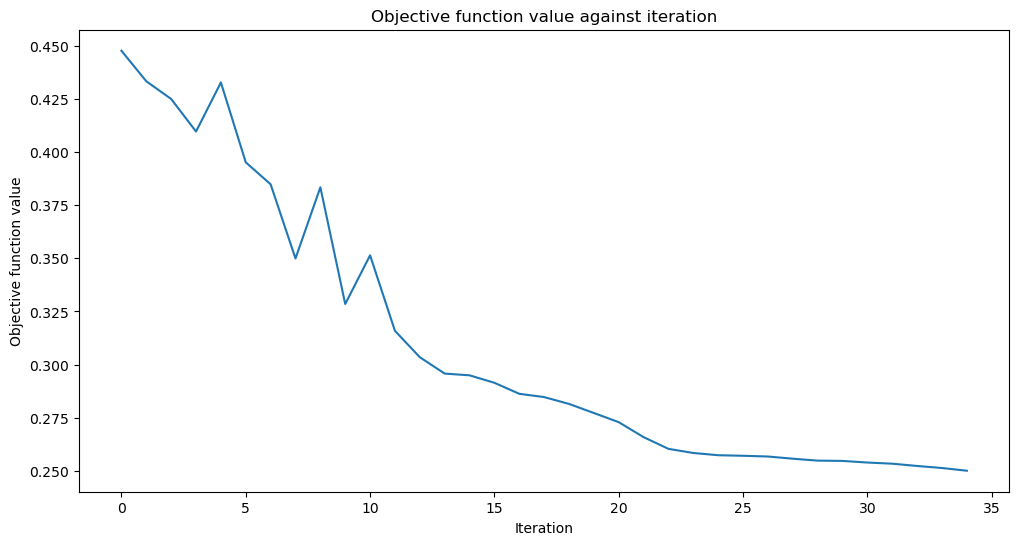

0.6531093175965038

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(conjunto_train, objetivo_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(conjunto_train, objetivo_train)

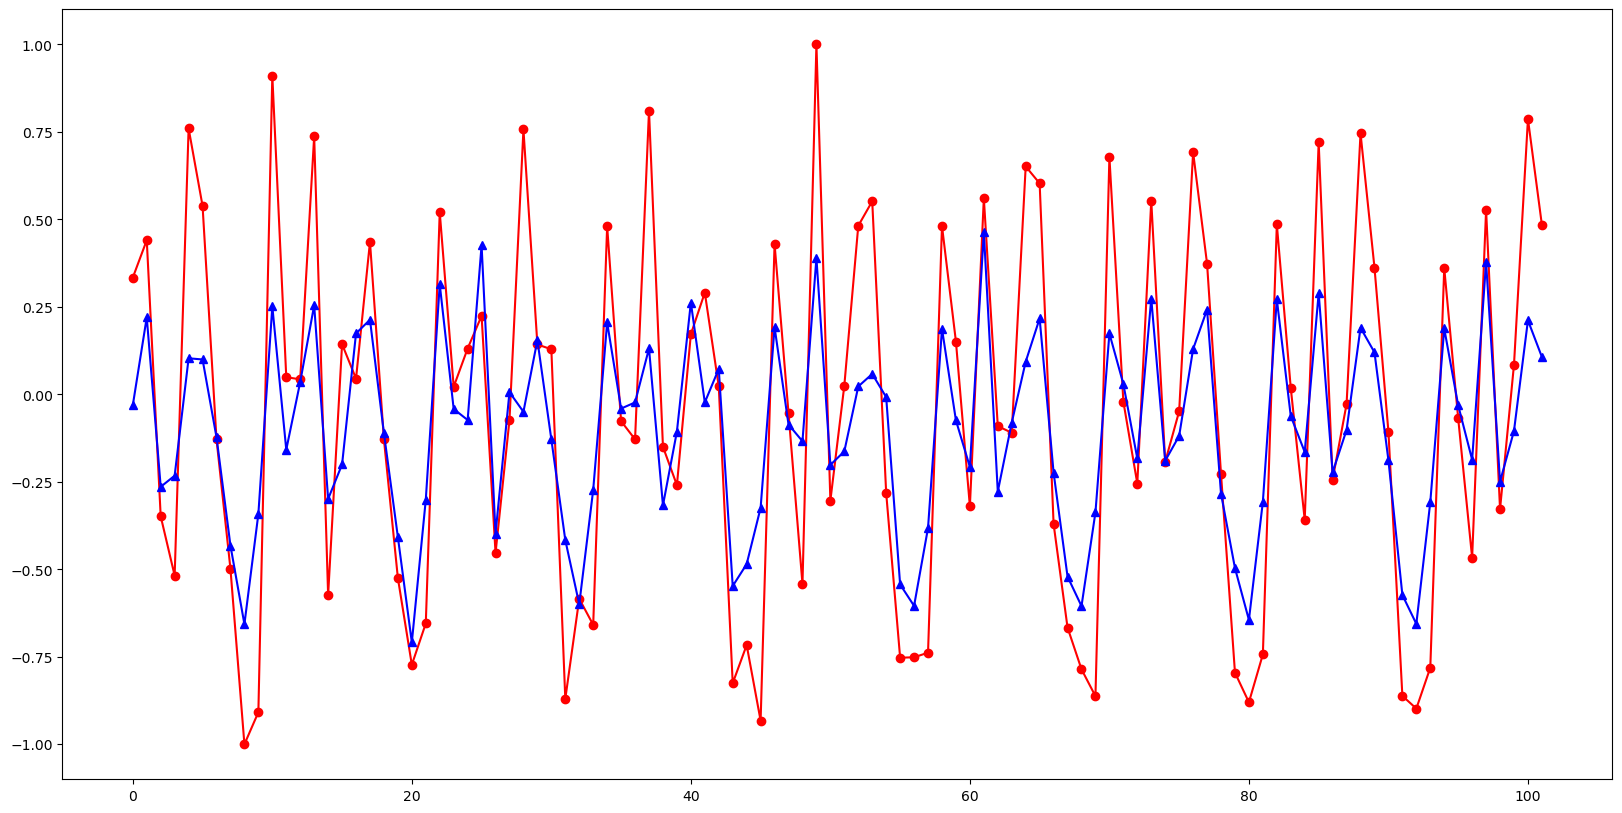

array([-3.32363154e-01, -4.77365316e-02,  2.97413428e-01, -2.11672672e-01,
       -1.62738786e-01, -1.19868828e-01,  1.72353294e-04, -1.31216808e-02,
       -1.86664175e-01, -2.50051304e-01,  7.86502586e-03,  1.50452901e-01,
        1.15252529e+00,  8.17455510e-01, -6.43725077e-01,  1.22895356e+00,
        8.96208593e-02,  2.44684409e-02,  1.59063023e+00,  1.54868523e+00,
       -9.35088087e-02, -1.69687643e-02,  1.56363755e+00,  4.05445567e-01,
       -3.69449092e-02,  1.58988181e+00,  2.93402075e-04, -2.48413252e-03,
        1.59376804e+00,  1.57759165e+00,  2.99130320e-03,  6.57739920e-03,
        1.54192712e+00,  1.48535380e+00,  2.91395767e-02,  1.17790301e+00,
       -7.86152970e-01,  3.74134260e-01,  1.53507087e+00,  1.01130393e-01,
        1.59612783e+00, -2.75196315e-02,  9.23779084e-02,  1.51386439e+00,
        9.52828330e-01, -2.41112253e-02,  2.90323618e-02,  8.23450154e-01])

In [16]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = vqr.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor2.weights